In [3]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import os
from glob import glob

sns.set_style('white')


con = sqlite3.connect('../../../Data/experiment_data.db')
subjs = pd.read_sql_query('SELECT * FROM subjects WHERE completion = 1', con)
dat = pd.read_sql_query('SELECT A.jspsychID,  A.trial_num, A.stimulus, A.cause_resp, A.anim_resp, A.cause_rt, A.anim_rt,'
            'A.trial_rt,A.time_elapse, A.subject_id '
            'FROM trials A INNER JOIN subjects B ON A.subject_id = B.id WHERE B.completion = 1', con)
# Just to be safe, filter for subjects who completed 48 trials
sub_list = []
for subj in subjs.id:
    if len(dat.loc[dat.subject_id == subj]) == 48:
        sub_list.append(subj)

dat = dat.loc[dat.subject_id.isin(sub_list)].sort_values(['subject_id', 'trial_num']).reset_index(drop=True)
# Use the stimulus file to make column for condition
dat = pd.concat([dat, pd.DataFrame(columns=['vid_num', 'agent', 'outcome', 'cf']).reindex(dat.index)], axis=1)
for i in range(len(dat)):
    dat.loc[i, ['vid_num', 'agent', 'outcome', 'cf']] = dat.iloc[i]['stimulus'].split('.')[0].split('_')
# rename some variables for clarity
dat['agent'] = dat.agent.replace({'a':'animate', 'p':'inanimate'})
dat.rename(columns={'cause_resp': 'causal_rating', 'anim_resp':'animacy_rating'}, inplace=True)
dat.reset_index(drop=True, inplace=True)
#dat.to_csv('../Data/experiment_data_10_01_2021.csv')
'''
dat = pd.read_csv('../../Data/experiment_data_10_01_2021.csv', index_col=0)
'''

"\ndat = pd.read_csv('../../Data/experiment_data_10_01_2021.csv', index_col=0)\n"

In [8]:
# filter for single subject
subdat = dat.loc[dat.subject_id == 130 ].reset_index(drop=True)

In [9]:
#plt.plot(subdat.time_elapse)
# isolate just animacy rating time from cause rating time.
subdat['anim_rt'] = subdat.anim_rt - subdat.cause_rt
# account for time between moving slider and hitting submit button
subdat['time_to_submit'] = subdat.trial_rt  - (subdat.cause_rt + subdat.anim_rt)
# for the first trial we expect trial_rt and time_elapse to be the same.
tare = subdat.loc[0, 'time_elapse'] - subdat.loc[0, 'trial_rt'] # this difference should capture time in instructions etc.
subdat['time_elapse'] = subdat.time_elapse - tare
# time elapsed at time t, should equal time elapsed at t-1 + trial_rt at t
#subdat.loc[t-1, 'time_elapse'] + subdat.loc[t, 'trial_rt']
#t = 2
subdat['fixation'] = 0
for t in range(1, 48):
    # any difference must be attributable to fixation
    subdat.loc[t, 'fixation'] = subdat.loc[t, 'time_elapse'] - (subdat.loc[t-1, 'time_elapse'] + subdat.loc[t, 'trial_rt'])

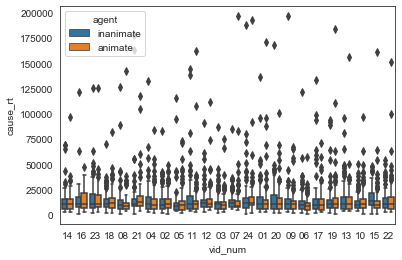

In [14]:
sns.boxplot(x='vid_num', y='cause_rt', hue='agent', data=dat.loc[dat.cause_rt < 200000])

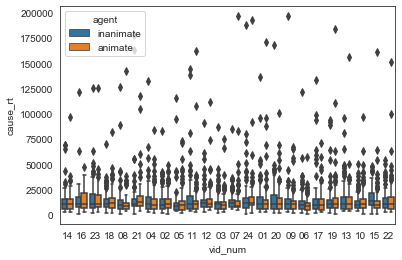

In [14]:
sns.boxplot(x='vid_num', y='cause_rt', hue='agent', data=dat.loc[dat.cause_rt < 200000])

In [2]:
'''
#De-mean each subject

dm_dat = dat
sdat = dat.groupby('subject_id').mean().causal_rating
for s in dat.subject_id.unique():
    dm_dat.loc[dm_dat.subject_id == s, 'causal_rating'] = dat.loc[dat.subject_id == s, 'causal_rating'] - sdat.loc[s]
'''


"\n#De-mean each subject\n\ndm_dat = dat\nsdat = dat.groupby('subject_id').mean().causal_rating\nfor s in dat.subject_id.unique():\n    dm_dat.loc[dm_dat.subject_id == s, 'causal_rating'] = dat.loc[dat.subject_id == s, 'causal_rating'] - sdat.loc[s]\n"

# Manipulation Check

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


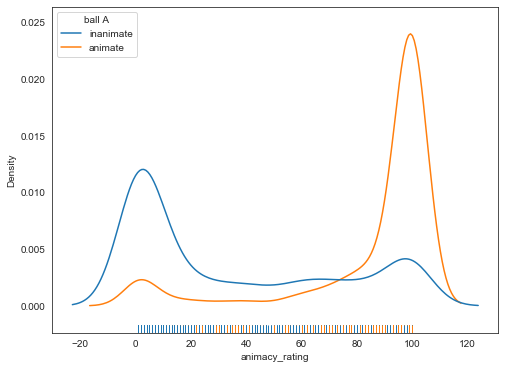

In [4]:
# Distribution of Animacy Ratings
f, a = plt.subplots(figsize=(8, 6))
sns.kdeplot(data=dat, x='animacy_rating', hue='ball A', ax=a)
sns.rugplot(data=dat, x='animacy_rating', hue='ball A', ax=a)
#plt.savefig('../../Plots/animacyRatingDists.png')

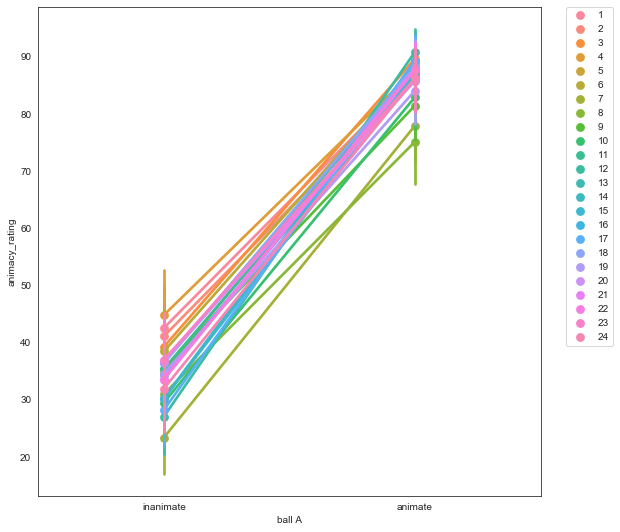

In [5]:
# Change in Animacy rating by trajectory
f, a = plt.subplots(figsize=(9,9))
sns.pointplot(data=dat, x='ball A', y='animacy_rating', hue='vid_num', ax=a)
a.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.savefig('../../Plots/animRatingXvid.png')

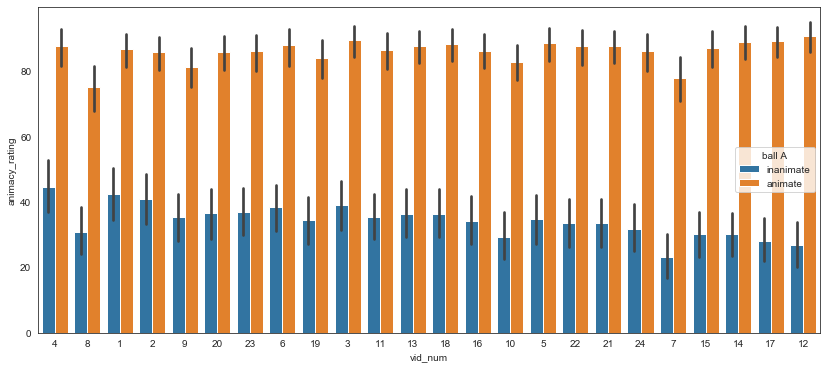

In [6]:
# difference in animacy rating by trajectory sorted from smallest to largest
anim_diffs = dat.groupby(['vid_num', 'ball A']).mean().animacy_rating
# sort the videos based on the difference of the mean animacy ratings per video
anim_diffs = anim_diffs.diff(-1).xs('animate', level=1).abs().sort_values()
plt.subplots(figsize=(14,6))
sns.barplot(data=dat, x='vid_num', y='animacy_rating', hue='ball A', order=anim_diffs.index.tolist())
#plt.savefig('../../Plots/animDiffsXvid.png')

# 2. Causal Ratings by Animacy Condition

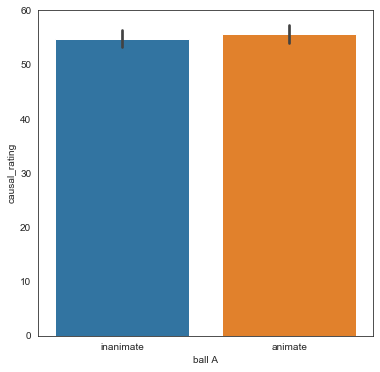

In [7]:
# causal rating by animacy condition
plt.subplots(figsize=(6,6))
sns.barplot(data=dat, x='ball A', y='causal_rating')
#plt.savefig('../../Plots/causeXagent.png')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


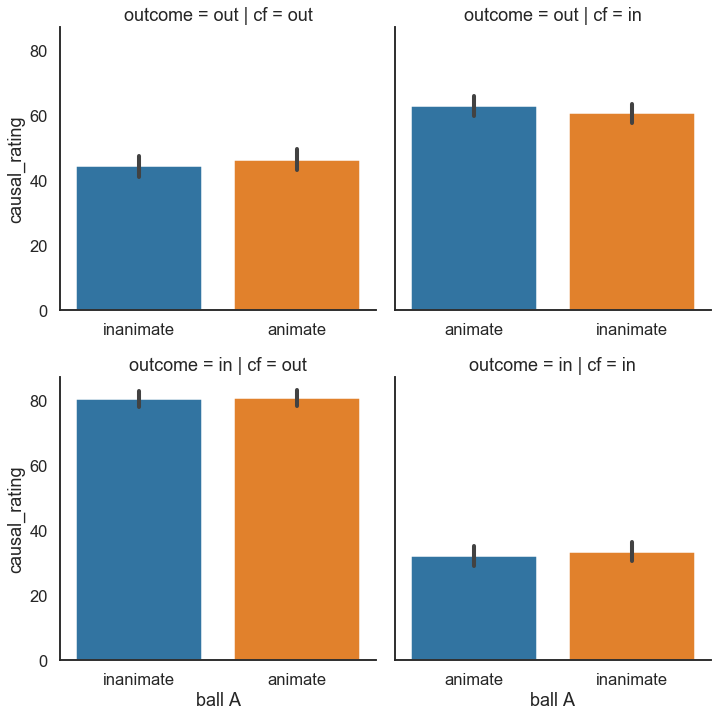

In [14]:
# mean causal rating by animacy condition by trajectory condition
sns.catplot(data=dat, x='ball A', y='causal_rating', col='cf', row='outcome', kind='bar', sharex=False)
#plt.savefig('../../Plots/causeXagentXcond.png')

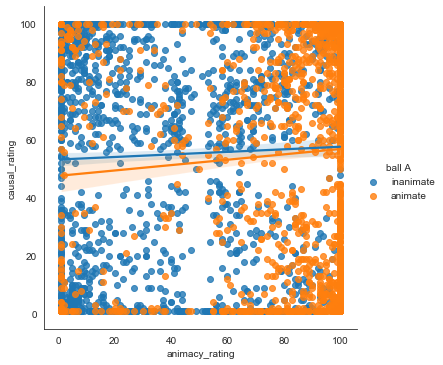

In [8]:
# causal rating by animacy rating
sns.lmplot(data=dat, x='animacy_rating', y='causal_rating', hue='ball A')

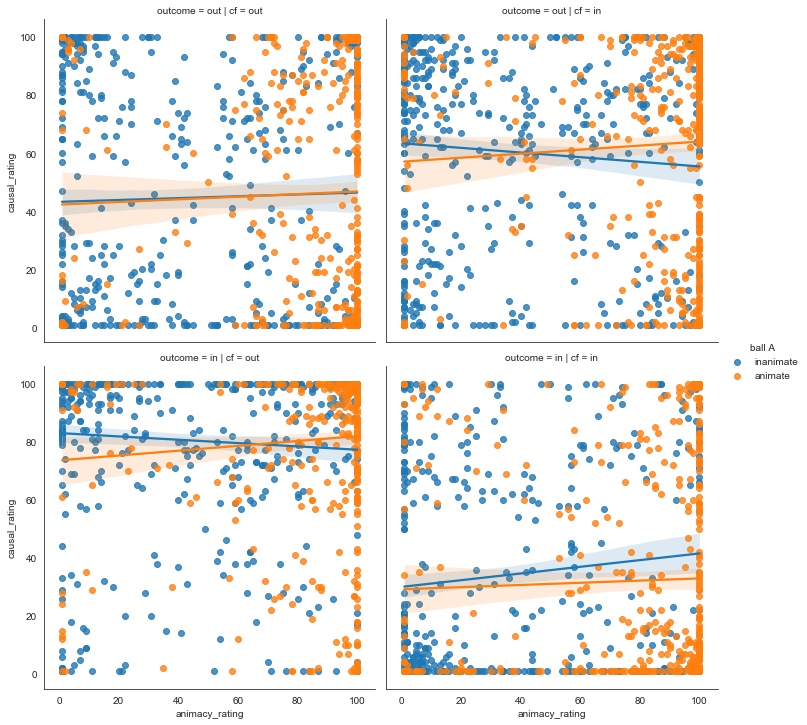

In [3]:
# Causal Rating x Animacy Rating x Trajectory condition
dat['traj_cond'] = 'outcome:'+dat['outcome']+' cf:'+dat['cf']
#sns.lmplot(x='animacy_rating', y='causal_rating', hue='ball A', data=dat, col='traj_cond')

#sns.set_context('notebook')
sns.lmplot(data=dat, x='animacy_rating', y='causal_rating', hue='ball A', col='cf', row='outcome',)
#plt.savefig('../../Plots/causeXanim.png')

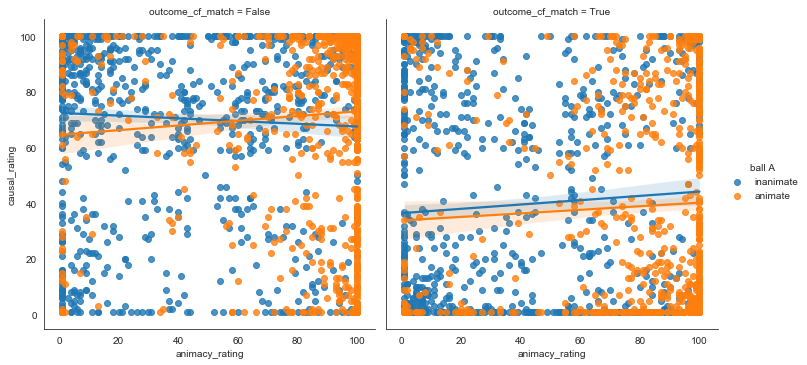

In [4]:
dat['outcome_cf_match'] = dat.outcome == dat.cf
sns.lmplot(data=dat, x='animacy_rating', y='causal_rating', hue='ball A', col='outcome_cf_match')

Ball B trajectory differences between collision and counterfactual

In [5]:
def trajectory_difference(traj1, traj2, ball, plot=False, cf=False, verbose=False):
    """
    Function to compute the distance between a given ball in two trajectories.

    :param traj1: pandas Dataframe with columns 'A' & 'B' where each index is a frame and values are the xyz coordinates of each ball.
    :param traj2: pandas Dataframe with columns 'A' & 'B' where each index is a frame and values are the xyz coordinates of each ball.
    :param ball: str: the ball you're interest
    :param plot: Bool: whether or not you want to visuali
    :param verbose: Bool: whether to print sum of the distance between 'ball' in trajectories.
    :return: list: the of the distance between 'ball' in traj1 and traj 2 for each frame.
    """
    t_diffs = []
    for t in range(len(traj1)):
        t_diffs.append(np.linalg.norm(np.asarray(traj1.loc[t, ball]) - np.asarray(traj2.loc[t, ball])))
    if ball == 'A': # compute difference only after the collision
        traj1['distance']= [np.linalg.norm(np.asarray(traj1.loc[t, 'A']) - np.asarray(traj1.loc[t, 'B'])) for t in range(250)]
        t_collision = traj1['distance'].idxmin()  #becuase python starts w 0
        t_diffs = t_diffs[t_collision:]

    if plot:
        plt.plot(t_diffs)
    total_diff = sum(t_diffs)
    if verbose:
        print(f'total difference between ball trajectories: {total_diff}')
    if cf:
        x = np.array(t_diffs)
        return np.mean(x[x>0])

    return total_diff

def get_trajectory(path):
    traj = pd.read_csv(path,  names=['A', 'B'])
    for ball in ['A', 'B']:
        traj[ball] =  traj[ball].apply(literal_eval)
    return traj


def get_velocity(traj, at_collision=False, pre_collision=False):
    traj.loc[1:249, 'A_fwd'] = [np.linalg.norm(np.array(traj.A[t-1]) - np.array(traj.A[t])) for t in range(1, len(traj))]
    #vel = np.gradient(traj.A_fwd.cumsum())
    #vel = traj.A_fwd.cumsum()
    vel = traj.A_fwd
    if at_collision:
        dist = pd.Series([np.linalg.norm(np.asarray(traj.loc[t, 'A']) - np.asarray(traj.loc[t, 'B'])) for t in range(len(traj))])
        t_collision = dist.iloc[30:].idxmin() #looking from frame 30 on because in vid 9/10, balls overlap before the animation, so the .minidx() is artificially early.
        return vel[t_collision]
    if pre_collision:
        dist = pd.Series([np.linalg.norm(np.asarray(traj.loc[t, 'A']) - np.asarray(traj.loc[t, 'B'])) for t in range(len(traj))])
        t_collision = dist.iloc[30:].idxmin()
        return vel[:t_collision]

    return vel


def plot_stimTrajectory(stim1, stim2,stim3, filename=None):
    f, a = plt.subplots(figsize=(15, 5), ncols=3, sharey=True)

    a[0].scatter(*zip(*stim1.B))
    a[0].scatter(*zip(*stim1.A), color='r')
    a[0].set_title("INANIMATE")
    a[0].set_aspect(2)
    a[1].scatter(*zip(*stim2.B))
    a[1].scatter(*zip(*stim2.A), color='r')
    a[1].set_title("ANIMATE")
    a[1].set_aspect(2)
    a[2].scatter(*zip(*stim3.B))
    a[2].set_title("COUNTERFACTUAL")
    a[2].set_aspect(2)
    if filename:
        plt.savefig(filename, dpi=80)

def plot_trajectory(stimulus, plot_labels, filename=None):
    """

    :param stimulus: pd.Dataframe or list of pd.Dataframes with columns 'A' and 'B'
    :param filename: str, path and filename to save
    :param plot_labels: list, list of strings denoting stimulus types (inanimate, animate, cf) in stimulus arg. MUST be in the same order as stimulus list
    :return:
    """
    if type(stimulus) != list:
        stimulus = [stimulus]
    f, a = plt.subplots(figsize=((5*len(stimulus)), 5), ncols=3, nrows=int(len(stimulus)/3),  sharey=True)
    for i, stim in enumerate(stimulus):
        a[i].scatter(*zip(*stim.B))
        if plot_labels[i] != 'Counterfactual':
            a[i].scatter(*zip(*stim.A), color='r')
        a[i].set_title(plot_labels[i])
        a[i].set_aspect(2)
    if filename:
        plt.savefig(filename, dpi=80)

def plotAllTrajectories(vid_dat=None, filename=None):
    anim_trajFiles = sorted(glob(os.path.join('../collisions/trajectory_files', '*_a_*')))
    phys_trajFiles = sorted(glob(os.path.join('../collisions/trajectory_files', '*_p_*')))
    cf_trajFiles = sorted(glob(os.path.join('../collisions/trajectory_files', '*_cf_*')))

    plt.rcParams["figure.autolayout"] = True
    im = plt.imread('table.png')
    im[:, :, -1] = .3


    f, ax = plt.subplots(figsize=(15, (5*24)), ncols=3, nrows=24,  sharey=True)
    for row, (anim, phys, cf) in enumerate(zip(anim_trajFiles, phys_trajFiles, cf_trajFiles)):
        traj_a = get_trajectory(anim)
        traj_p = get_trajectory(phys)
        traj_cf = get_trajectory(cf)
        if vid_dat is not None:
            ax[row, 2].scatter(*vid_dat.loc[vid_dat.vid_num == int(row+1)].p0.values[0], color='y', zorder=2)
            ax[row, 2].scatter(*vid_dat.loc[vid_dat.vid_num == int(row+1)].p1.values[0], color='y', zorder=2)

        for col, (stim, label, cond) in enumerate(zip([traj_p, traj_a, traj_cf], ['inanimate','animate', 'Counterfactual'], (anim, phys, cf))):
            ax[row, col].imshow(im, zorder=1, extent=[0, 61.5, -1, 31])
            ax[row, col].scatter(*zip(*stim.B), zorder=2)
            condition = cond.split('/')[-1].split('.')[0].split('_')

            if label != 'Counterfactual':
                ax[row, col].scatter(*zip(*stim.A), color='r', zorder=2)
                if vid_dat is not None:
                    caus_mean = round(vid_dat.loc[(vid_dat.vid_num == int(condition[0])) & (vid_dat['ball A'] == label), 'causal_rating'].values[0], 2)

                    ax[row, col].text(5, 25, f"M = {caus_mean}", fontsize=18, color='w' )
            ax[row, col].set_title('stim'+str(row+1)+' '+label+' outcome: '+condition[2]+' cf: '+condition[3])
            ax[row,col].set_ylim(ymin=0.0)
            ax[row, col].xaxis.set_visible(False)
            ax[row, col].yaxis.set_visible(False)


    if filename:
        plt.savefig(filename, dpi=80)

In [ ]:
anim_trajFiles = sorted(glob(os.path.join('../collisions/trajectory_files', '*_a_*')))
phys_trajFiles = sorted(glob(os.path.join('../collisions/trajectory_files', '*_p_*')))
cf_trajFiles = sorted(glob(os.path.join('../collisions/trajectory_files', '*_cf_*')))

# Ambiguity of Counterfactuals

Confirmed that ball B's trajectory is matched across physical and animate stimuli by comparing them both
to the counterfactual

In [23]:
'''
scenarios:
in_out:
    - Target: ball B's final location in the physical trajectory
    - CF: ball B's location in CF at the frame where max X value(i.e. when it bounces off right wall)

in_in:
    - Target: ball B's final location in the phys trajectory.
    - CF: ball B's final location in the CF trajectory.

out_out:
    - Target: (50, 0) or (50, 25)
    - CF: ball B's location at max X value in the CF

out_in:
    - Target: ball B's final location in the CF trajectory as the goal.
    - CF: ball B's location in physical traj at the frame where max X value(i.e. when it bounces off right wall)

'''
vid_dat = dat.groupby(['vid_num', 'ball A']).mean()
vid_dat[['p0', 'p1']] = ''
vid_dat['closeness'] = 0
top_pocket = np.array([54.40703582763672, 25.04831886291504]) # got this values from blender file 1_p_in_out.blend
bottom_pocket = np.array([54.350181579589844, 2.945833206176758])# got this values from blender file 12a_in_in_rev.blend

for i in range(len(phys_trajFiles)):
    path = phys_trajFiles[i]
    cond = path.split('/')[-1].split('.')[0].split('_')
    phys_traj = get_trajectory(phys_trajFiles[i])
    cf_traj = get_trajectory(cf_trajFiles[i])

    if (cond[2]== 'in') and (cond[3] =='out'):
        p0 = np.array(phys_traj.iloc[-1].B[:2]) # just use XY, so 2D
        bb = cf_traj.B.apply(pd.Series)
        maxX = bb.loc[bb[0]== max(bb[0])].index[0]
        p1 = np.array(cf_traj.iloc[maxX].B[:2])
    if (cond[2]== 'in') and (cond[3] =='in'):
        p0 = np.array(phys_traj.iloc[-1].B[:2])
        if i == 9: #this is because I screwed up the counterfactual for vid 10
            p1 = np.array(phys_traj.iloc[-1].B[:2])
        else:
            p1 = np.array(cf_traj.iloc[-1].B[:2])
    if (cond[2]== 'out') and (cond[3] =='out'):
        bb = cf_traj.B.apply(pd.Series)
        maxX = bb.loc[bb[0]== max(bb[0])].index[0]
        p1 = np.array(cf_traj.iloc[maxX].B[:2])
        possibpocket = [np.linalg.norm(top_pocket - p1), np.linalg.norm(bottom_pocket - p1)]
        p0 = np.array([top_pocket, bottom_pocket])[possibpocket == min(possibpocket)][0]
    if (cond[2]== 'out') and (cond[3] =='in'):
        p0 = np.array(cf_traj.iloc[-1].B[:2])
        bb = cf_traj.B.apply(pd.Series)
        maxX = bb.loc[bb[0]== max(bb[0])].index[0]
        p1 = np.array(cf_traj.iloc[maxX].B[:2])

    dist = np.linalg.norm(p0 - p1)
    vid_dat.at[(i+1,'animate'), 'p0'] = tuple(p0)
    vid_dat.at[(i+1,'inanimate'), 'p0'] = tuple(p0)
    vid_dat.at[(i+1,'animate'), 'p1'] = tuple(p1)
    vid_dat.at[(i+1,'inanimate'), 'p1'] = tuple(p1)
    vid_dat.loc[(i+1,), 'closeness'] =  dist

vid_dat.reset_index(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/collections.py:857: RuntimeWarning: inv

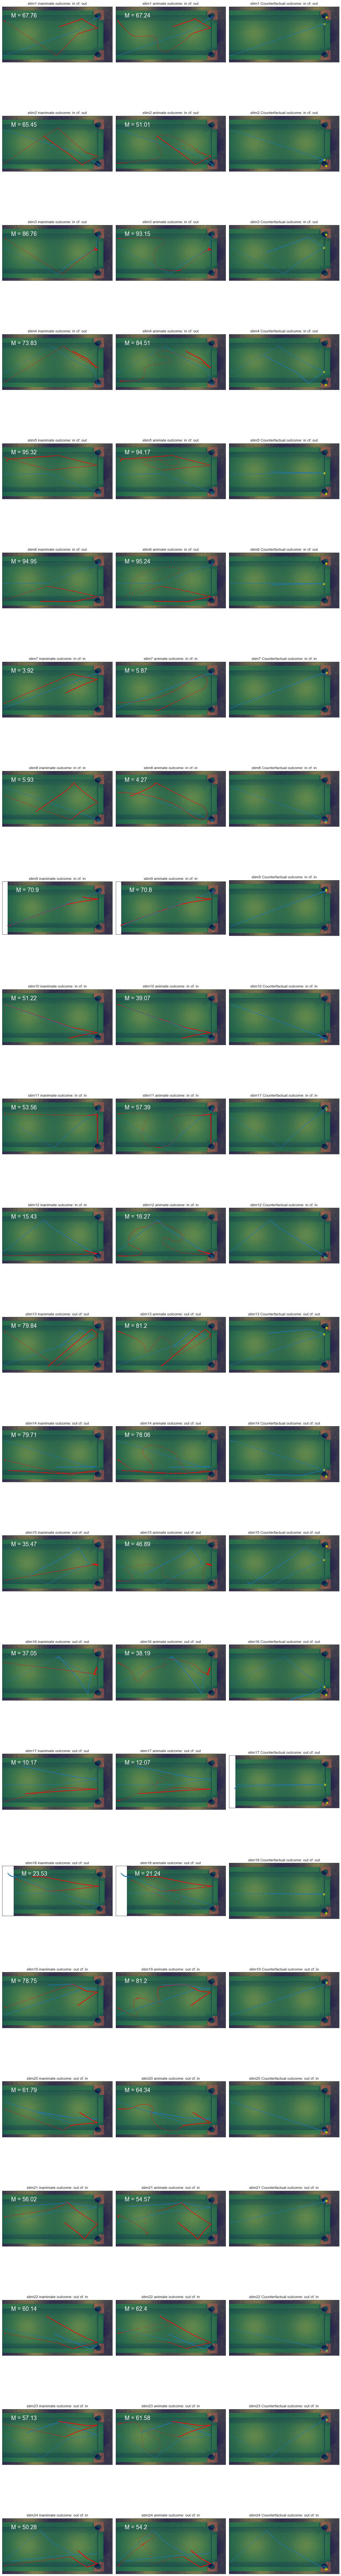

In [97]:
plotAllTrajectories(vid_dat=vid_dat, filename='../../Plots/pocket_proxim.pdf')

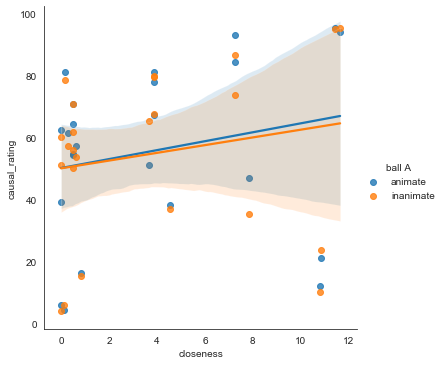

In [25]:
sns.lmplot(y='causal_rating', x='closeness', hue='ball A', data=vid_dat)
#plt.savefig('../../Plots/causeXcf_closeness.png')

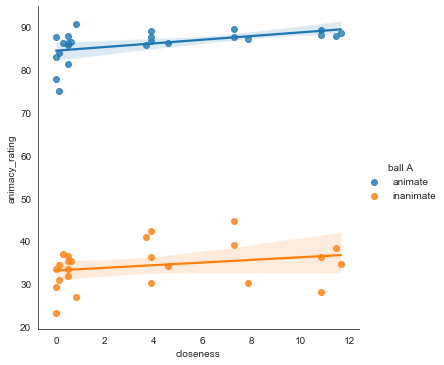

In [10]:
sns.lmplot(y='animacy_rating', x='closeness', hue='ball A', data=vid_dat)
plt.savefig('../../Plots/animXcf_closeness.png')

In [22]:
# This just prints out the sum of frame-wise differences in ball B between animate/inanim and CF.
# ran this just to confirm that both inanimate/animate stim match in their deviation from the CF
'''
for i, (a, p, cf) in enumerate(zip(anim_trajFiles, phys_trajFiles, cf_trajFiles)):
    traj_a = get_trajectory(a)
    traj_p = get_trajectory(p)
    traj_cf = get_trajectory(cf)
    print(f'trajectory number: {i+1}, animate vs counterfactual')
    trajectory_difference(traj_a, traj_cf, 'B', verbose=True)
    print(f'trajectory number: {i+1}, physical vs counterfactual')
    trajectory_difference(traj_p, traj_cf, 'B', verbose=True)
'''


"\nfor i, (a, p, cf) in enumerate(zip(anim_trajFiles, phys_trajFiles, cf_trajFiles)):\n    traj_a = get_trajectory(a)\n    traj_p = get_trajectory(p)\n    traj_cf = get_trajectory(cf)\n    print(f'trajectory number: {i+1}, animate vs counterfactual')\n    trajectory_difference(traj_a, traj_cf, 'B', verbose=True)\n    print(f'trajectory number: {i+1}, physical vs counterfactual')\n    trajectory_difference(traj_p, traj_cf, 'B', verbose=True)\n"

In [4]:
vid_dat = dat.groupby(['vid_num', 'ball A']).mean()
vid_dat['cf_deviation'] = 0
vid_dat['ball A velocity'] = 0
for i, (a, p, cf) in enumerate(zip(anim_trajFiles, phys_trajFiles, cf_trajFiles)):
    traj_a = get_trajectory(a)
    traj_p = get_trajectory(p)
    traj_cf = get_trajectory(cf)
    a_cf_diff = trajectory_difference(traj_a, traj_cf, 'B', cf=True)
    p_cf_diff = trajectory_difference(traj_p, traj_cf, 'B', cf=True)
    v_p = get_velocity(traj_p, at_collision=True)
    v_a = get_velocity(traj_a, at_collision=True)
    vid_dat.loc[(i+1, 'inanimate'), 'cf_deviation'] = p_cf_diff
    vid_dat.loc[(i+1, 'animate'), 'cf_deviation'] = a_cf_diff
    vid_dat.loc[(i+1, 'inanimate'), 'ball A velocity'] = np.mean(v_p[v_p > 0])
    vid_dat.loc[(i+1, 'animate'), 'ball A velocity'] = np.mean(v_a[v_a > 0])#get_velocity(traj_a, pre_collision=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
vid_dat.reset_index(inplace=True)

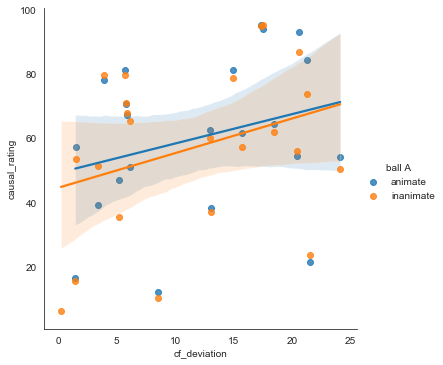

In [6]:
#sns.set_context('notebook')
sns.lmplot(x='cf_deviation', y='causal_rating', data=vid_dat, hue='ball A')

In [55]:
sns.set_context('talk')

vdat = vid_dat.melt(id_vars=['cf_deviation','ball A velocity',  'ball A', 'vid_num'], value_vars=['causal_rating', 'animacy_rating'],
             var_name='prompt', value_name='rating')

In [ ]:
sns.lmplot(x='cf_deviation', y='rating', col='prompt', data=vdat, hue='ball A', height=8, aspect=1)
#plt.savefig('../../Plots/causeXcf_diffs.png')

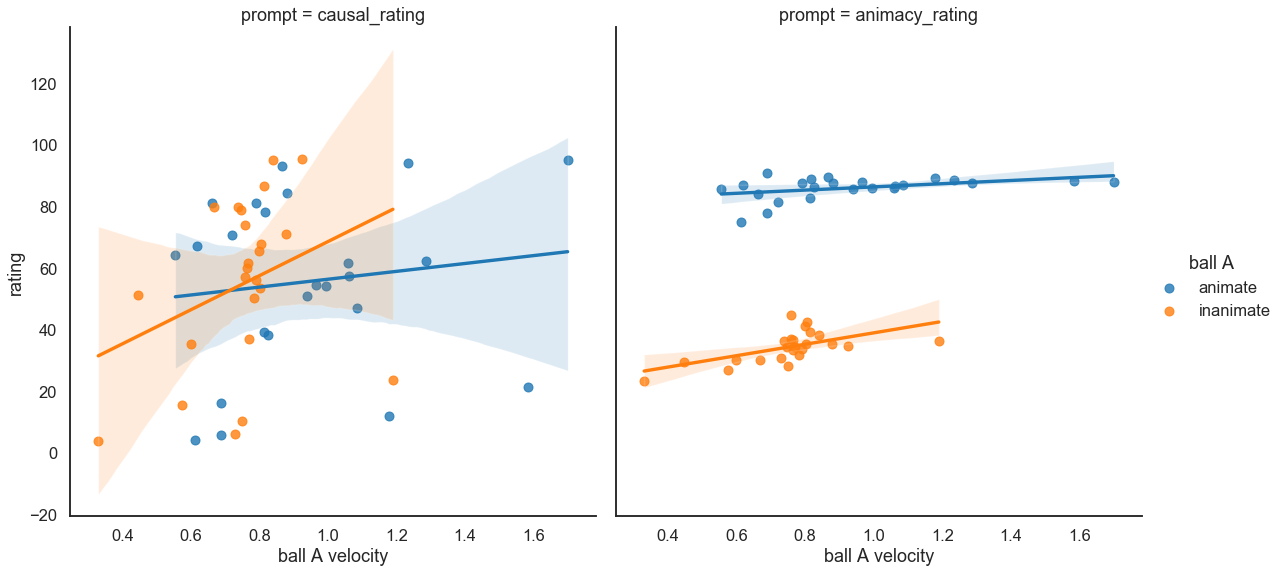

In [47]:
sns.lmplot(x='ball A velocity', y='rating', col='prompt', data=vdat, hue='ball A', height=8, aspect=1)
#plt.savefig('../../Plots/causeXvelocity.png')

# Velocity of the Agent before and at collision

In [ ]:
#average speed
sns.lmplot(x='ball A velocity', y='rating', col='prompt', data=vdat, hue='ball A', height=8, aspect=1)
plt.savefig('../../Plots/causeXcollisionVelocity.png')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


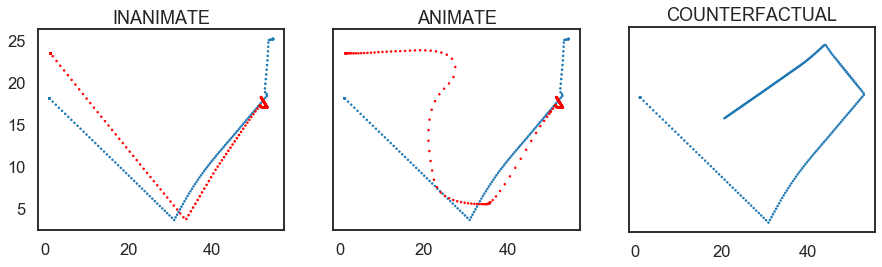

In [32]:
p3 = get_trajectory(phys_trajFiles[2])
a3 = get_trajectory(anim_trajFiles[2])
cf3 = get_trajectory(cf_trajFiles[2])

plot_stimTrajectory(p3, a3, cf3, '../../Plots/example_trajectory.png')

# exploring reaction time data

In [68]:
# start by just looking at one subject.
sdat = dat.loc[dat.subject_id == 150]
#plt.plot(sdat.time_elapse)
# time_elapse : monotonically increasing over trials. The final value per subject is the total time it took to complete the trials.
# Let try to make it minutes:seconds formate
exp_dur1 = (sdat.loc[sdat.trial_num == 48].time_elapse.values[0] / 1000)/60

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


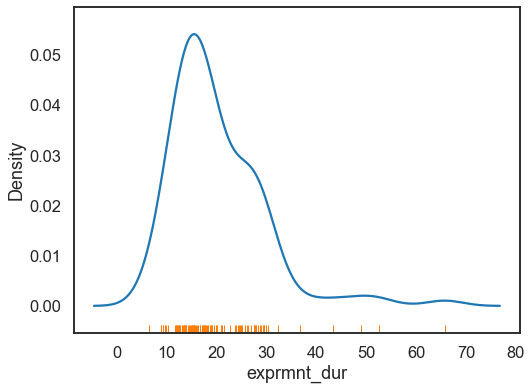

In [74]:
# make a df with subjects and duration to see the distribution of duration times.
exp_times = pd.DataFrame({'subject_id': dat.subject_id.unique(),
                          'exprmnt_dur': 0})

for subj in exp_times.subject_id.unique():
    sdat = dat.loc[dat.subject_id == subj]
    exp_dur = (sdat.loc[sdat.trial_num == 48].time_elapse.values[0] / 1000)/60
    exp_times.loc[exp_times.subject_id == subj, 'exprmnt_dur'] = exp_dur
# lets plot this distribution
f, a = plt.subplots(figsize=(8, 6))
sns.kdeplot(data=exp_times, x='exprmnt_dur', ax=a)
sns.rugplot(data=exp_times, x='exprmnt_dur', ax=a)

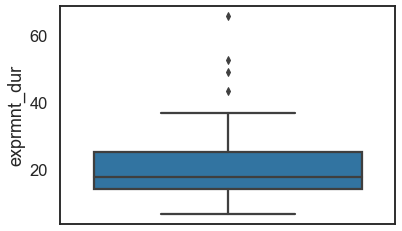

In [75]:
sns.boxplot(data=exp_times, y='exprmnt_dur')

In [76]:
exp_times.describe()

,subject_id,exprmnt_dur
count,103.000000,103.000000
mean,74.737864,20.109950
std,40.308847,9.320992
min,7.000000,6.541483
25%,41.500000,13.878208
50%,73.000000,17.528900
75%,104.500000,25.047617
max,150.000000,65.711167


In [77]:
exp_times.loc[exp_times.exprmnt_dur == min(exp_times.exprmnt_dur)]



,subject_id,exprmnt_dur
84,117,6.541483


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


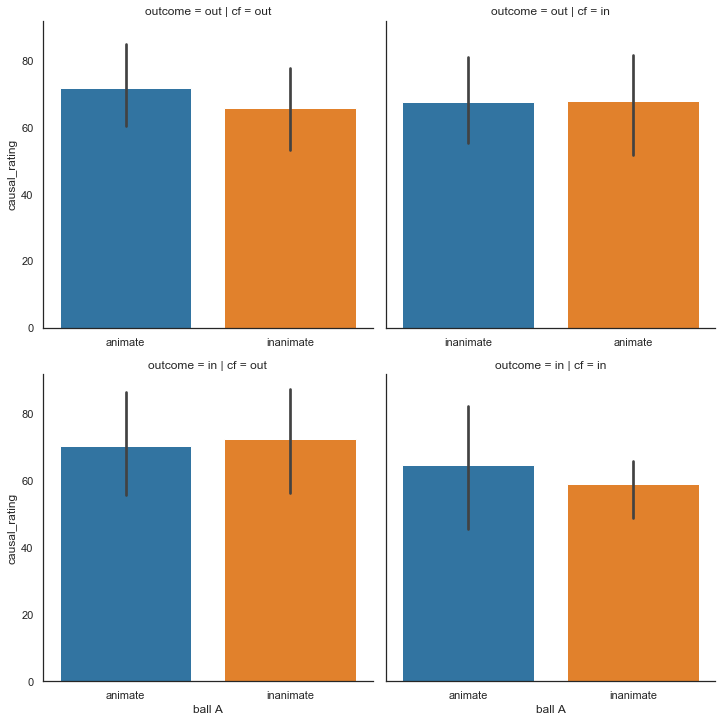

In [80]:
sns.set_context('notebook')
sdat = dat.loc[dat.subject_id == 117]
sns.catplot(data=sdat, x='ball A', y='causal_rating', col='cf', row='outcome', kind='bar', sharex=False)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


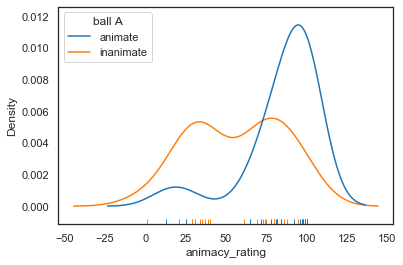

In [82]:
f, a = plt.subplots()
sns.kdeplot(data=sdat, x='animacy_rating', hue='ball A', ax=a)
sns.rugplot(data=sdat, x='animacy_rating', hue='ball A', ax=a)

In [ ]:
'''
Seems like some ppl took a long time and others a crazy short time, I believe they're humans
but TODO: repeat all analyses above using only subjects who finished the experiment within IQR.
'''